Der allererste Schritt ist, die Daten reinzuladen und zu sehen, wie 

In [8]:
import os
import pandas as pd
from datasets import load_dataset

# Stelle sicher, dass das data-Verzeichnis existiert
os.makedirs('data', exist_ok=True)

# Lade den FairJob-Datensatz
print("Lade FairJob-Datensatz...")
ds = load_dataset("criteo/FairJob")

# Der Datensatz hat verschiedene Splits (train, validation, test)
# Wir kombinieren alle Splits zu einem DataFrame
all_data = []

for split_name in ds.keys():
    print(f"Verarbeite Split: {split_name}")
    split_data = ds[split_name].to_pandas()
    # Füge eine Spalte hinzu, um den Split zu identifizieren
    split_data['split'] = split_name
    all_data.append(split_data)

# Kombiniere alle Daten
combined_df = pd.concat(all_data, ignore_index=True)

# Speichere als CSV
output_path = 'data/fairjob.csv'
combined_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"Datensatz erfolgreich gespeichert unter: {output_path}")
print(f"Anzahl Zeilen: {len(combined_df)}")
print(f"Anzahl Spalten: {len(combined_df.columns)}")
print(f"Spalten: {list(combined_df.columns)}")

# Zeige die ersten paar Zeilen an
print("\nErste 5 Zeilen:")
print(combined_df.head())

Lade FairJob-Datensatz...
Verarbeite Split: train
Datensatz erfolgreich gespeichert unter: data/fairjob.csv
Anzahl Zeilen: 1072226
Anzahl Spalten: 57
Spalten: ['click', 'protected_attribute', 'senior', 'displayrandom', 'rank', 'user_id', 'impression_id', 'product_id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'num25', 'num26', 'num27', 'num28', 'num29', 'num30', 'num31', 'num32', 'num33', 'num34', 'num35', 'num36', 'num37', 'num38', 'num39', 'num40', 'num41', 'num42', 'num43', 'num44', 'num45', 'num46', 'num47', 'num48', 'num49', 'num50', 'split']

Erste 5 Zeilen:
   click  protected_attribute  senior  displayrandom  rank  user_id  \
0      0                    0       1              1     1    31020   
1      0                    0       1              0     3      515   
2      0                    1       1              0     1    12859   

In [ ]:
import pandas as pd
import numpy as np

# Lade den gespeicherten Datensatz
df = pd.read_csv('data/fairjob.csv')

print("Original Datensatz Info:")
print(f"Gesamtanzahl Zeilen: {len(df)}")
print(f"Click Distribution:")
print(df['click'].value_counts())
print(f"Click Distribution (Prozent):")
print(df['click'].value_counts(normalize=True) * 100)

# 1. Erstelle 2 Gruppen basierend auf Click-Werten
group_0_clicks = df[df['click'] == 0].copy()  # Keine Clicks
group_1_clicks = df[df['click'] == 1].copy()  # Clicks

print(f"\nGruppe 0 (keine Clicks): {len(group_0_clicks)} Zeilen")
print(f"Gruppe 1 (Clicks): {len(group_1_clicks)} Zeilen")

# 2. Aus Gruppe 0 zufällig genau so viele auswählen wie in Gruppe 1
n_positive_samples = len(group_1_clicks)
print(f"\nWähle {n_positive_samples} zufällige Samples aus Gruppe 0...")

# Random sampling mit festem Seed für Reproduzierbarkeit
np.random.seed(42)
group_0_sampled = group_0_clicks.sample(n=n_positive_samples, random_state=42)

print(f"Ausgewählte Samples aus Gruppe 0: {len(group_0_sampled)}")

# Kombiniere die balancierten Daten
balanced_df = pd.concat([group_0_sampled, group_1_clicks], ignore_index=True)

# Mische die Daten
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalancierter Datensatz Info:")
print(f"Gesamtanzahl Zeilen: {len(balanced_df)}")
print(f"Click Distribution:")
print(balanced_df['click'].value_counts())
print(f"Click Distribution (Prozent):")
print(balanced_df['click'].value_counts(normalize=True) * 100)

# Speichere den balancierten Datensatz
output_path = 'data/fairjob_balanced.csv'
balanced_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nBalancierter Datensatz gespeichert unter: {output_path}")

# Zeige Vergleich
print(f"\n{'='*50}")
print("VERGLEICH:")
print(f"{'='*50}")
print(f"Original Datensatz: {len(df):,} Zeilen")
print(f"  - Keine Clicks (0): {len(group_0_clicks):,} ({len(group_0_clicks)/len(df)*100:.1f}%)")
print(f"  - Clicks (1): {len(group_1_clicks):,} ({len(group_1_clicks)/len(df)*100:.1f}%)")

print(f"\nBalancierter Datensatz: {len(balanced_df):,} Zeilen")
print(f"  - Keine Clicks (0): {len(group_0_sampled):,} (50.0%)")
print(f"  - Clicks (1): {len(group_1_clicks):,} (50.0%)")

print(f"\nDatenreduktion: {(1 - len(balanced_df)/len(df))*100:.1f}% der ursprünglichen Daten entfernt")

# Zeige die ersten paar Zeilen des balancierten Datensatzes
print(f"\nErste 10 Zeilen des balancierten Datensatzes:")
print(balanced_df[['click']].head(10))

# Optional: Zeige Statistiken für andere Spalten um sicherzustellen, 
# dass die Verteilung noch repräsentativ ist
print(f"\n{'='*50}")
print("VERTEILUNGSCHECK (erste paar Spalten):")
print(f"{'='*50}")

# Prüfe ein paar kategorische Spalten (falls vorhanden)
categorical_cols = balanced_df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols[:3]:  # Nur erste 3 kategorische Spalten
        if col != 'split':
            print(f"\n{col} Verteilung (balanciert):")
            print(balanced_df[col].value_counts().head())



Original Datensatz Info:
Gesamtanzahl Zeilen: 1072226
Click Distribution:
click
0    1064737
1       7489
Name: count, dtype: int64
Click Distribution (Prozent):
click
0    99.301547
1     0.698453
Name: proportion, dtype: float64

Gruppe 0 (keine Clicks): 1064737 Zeilen
Gruppe 1 (Clicks): 7489 Zeilen

Wähle 7489 zufällige Samples aus Gruppe 0...
Ausgewählte Samples aus Gruppe 0: 7489

Balancierter Datensatz Info:
Gesamtanzahl Zeilen: 14978
Click Distribution:
click
1    7489
0    7489
Name: count, dtype: int64
Click Distribution (Prozent):
click
1    50.0
0    50.0
Name: proportion, dtype: float64

Balancierter Datensatz gespeichert unter: data/fairjob_balanced.csv

VERGLEICH:
Original Datensatz: 1,072,226 Zeilen
  - Keine Clicks (0): 1,064,737 (99.3%)
  - Clicks (1): 7,489 (0.7%)

Balancierter Datensatz: 14,978 Zeilen
  - Keine Clicks (0): 7,489 (50.0%)
  - Clicks (1): 7,489 (50.0%)

Datenreduktion: 98.6% der ursprünglichen Daten entfernt

Erste 10 Zeilen des balancierten Datensatzes

Confusion Matrix:
[[1141  357]
 [ 346 1152]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7673    0.7617    0.7645      1498
           1     0.7634    0.7690    0.7662      1498

    accuracy                         0.7654      2996
   macro avg     0.7654    0.7654    0.7654      2996
weighted avg     0.7654    0.7654    0.7654      2996

ROC-AUC Score: 0.8434296462929656
Accuracy: 0.7653538050734312


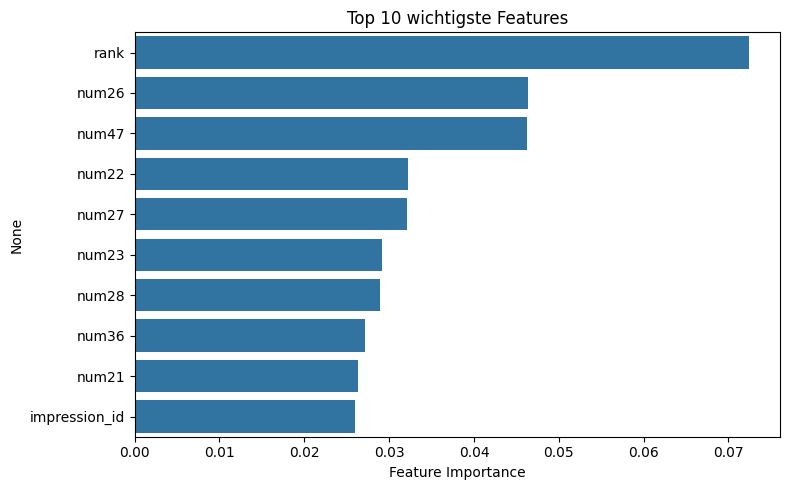

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Lade den balancierten Datensatz
df = pd.read_csv('data/fairjob_balanced.csv')

# Features und Ziel definieren
X = df.drop(columns=['click'])  # alle Spalten außer dem Label
y = df['click']                 # Zielvariable

# Optional: Falls noch kategorische Variablen enthalten sind → One-Hot-Encoding
X = pd.get_dummies(X)

# Aufteilen in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Modell erstellen
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight=None  # weil der Datensatz bereits balanciert ist
)

# Modell trainieren
rf.fit(X_train, y_train)

# Vorhersagen
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Wichtigste Features anzeigen (Top 10)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 wichtigste Features")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


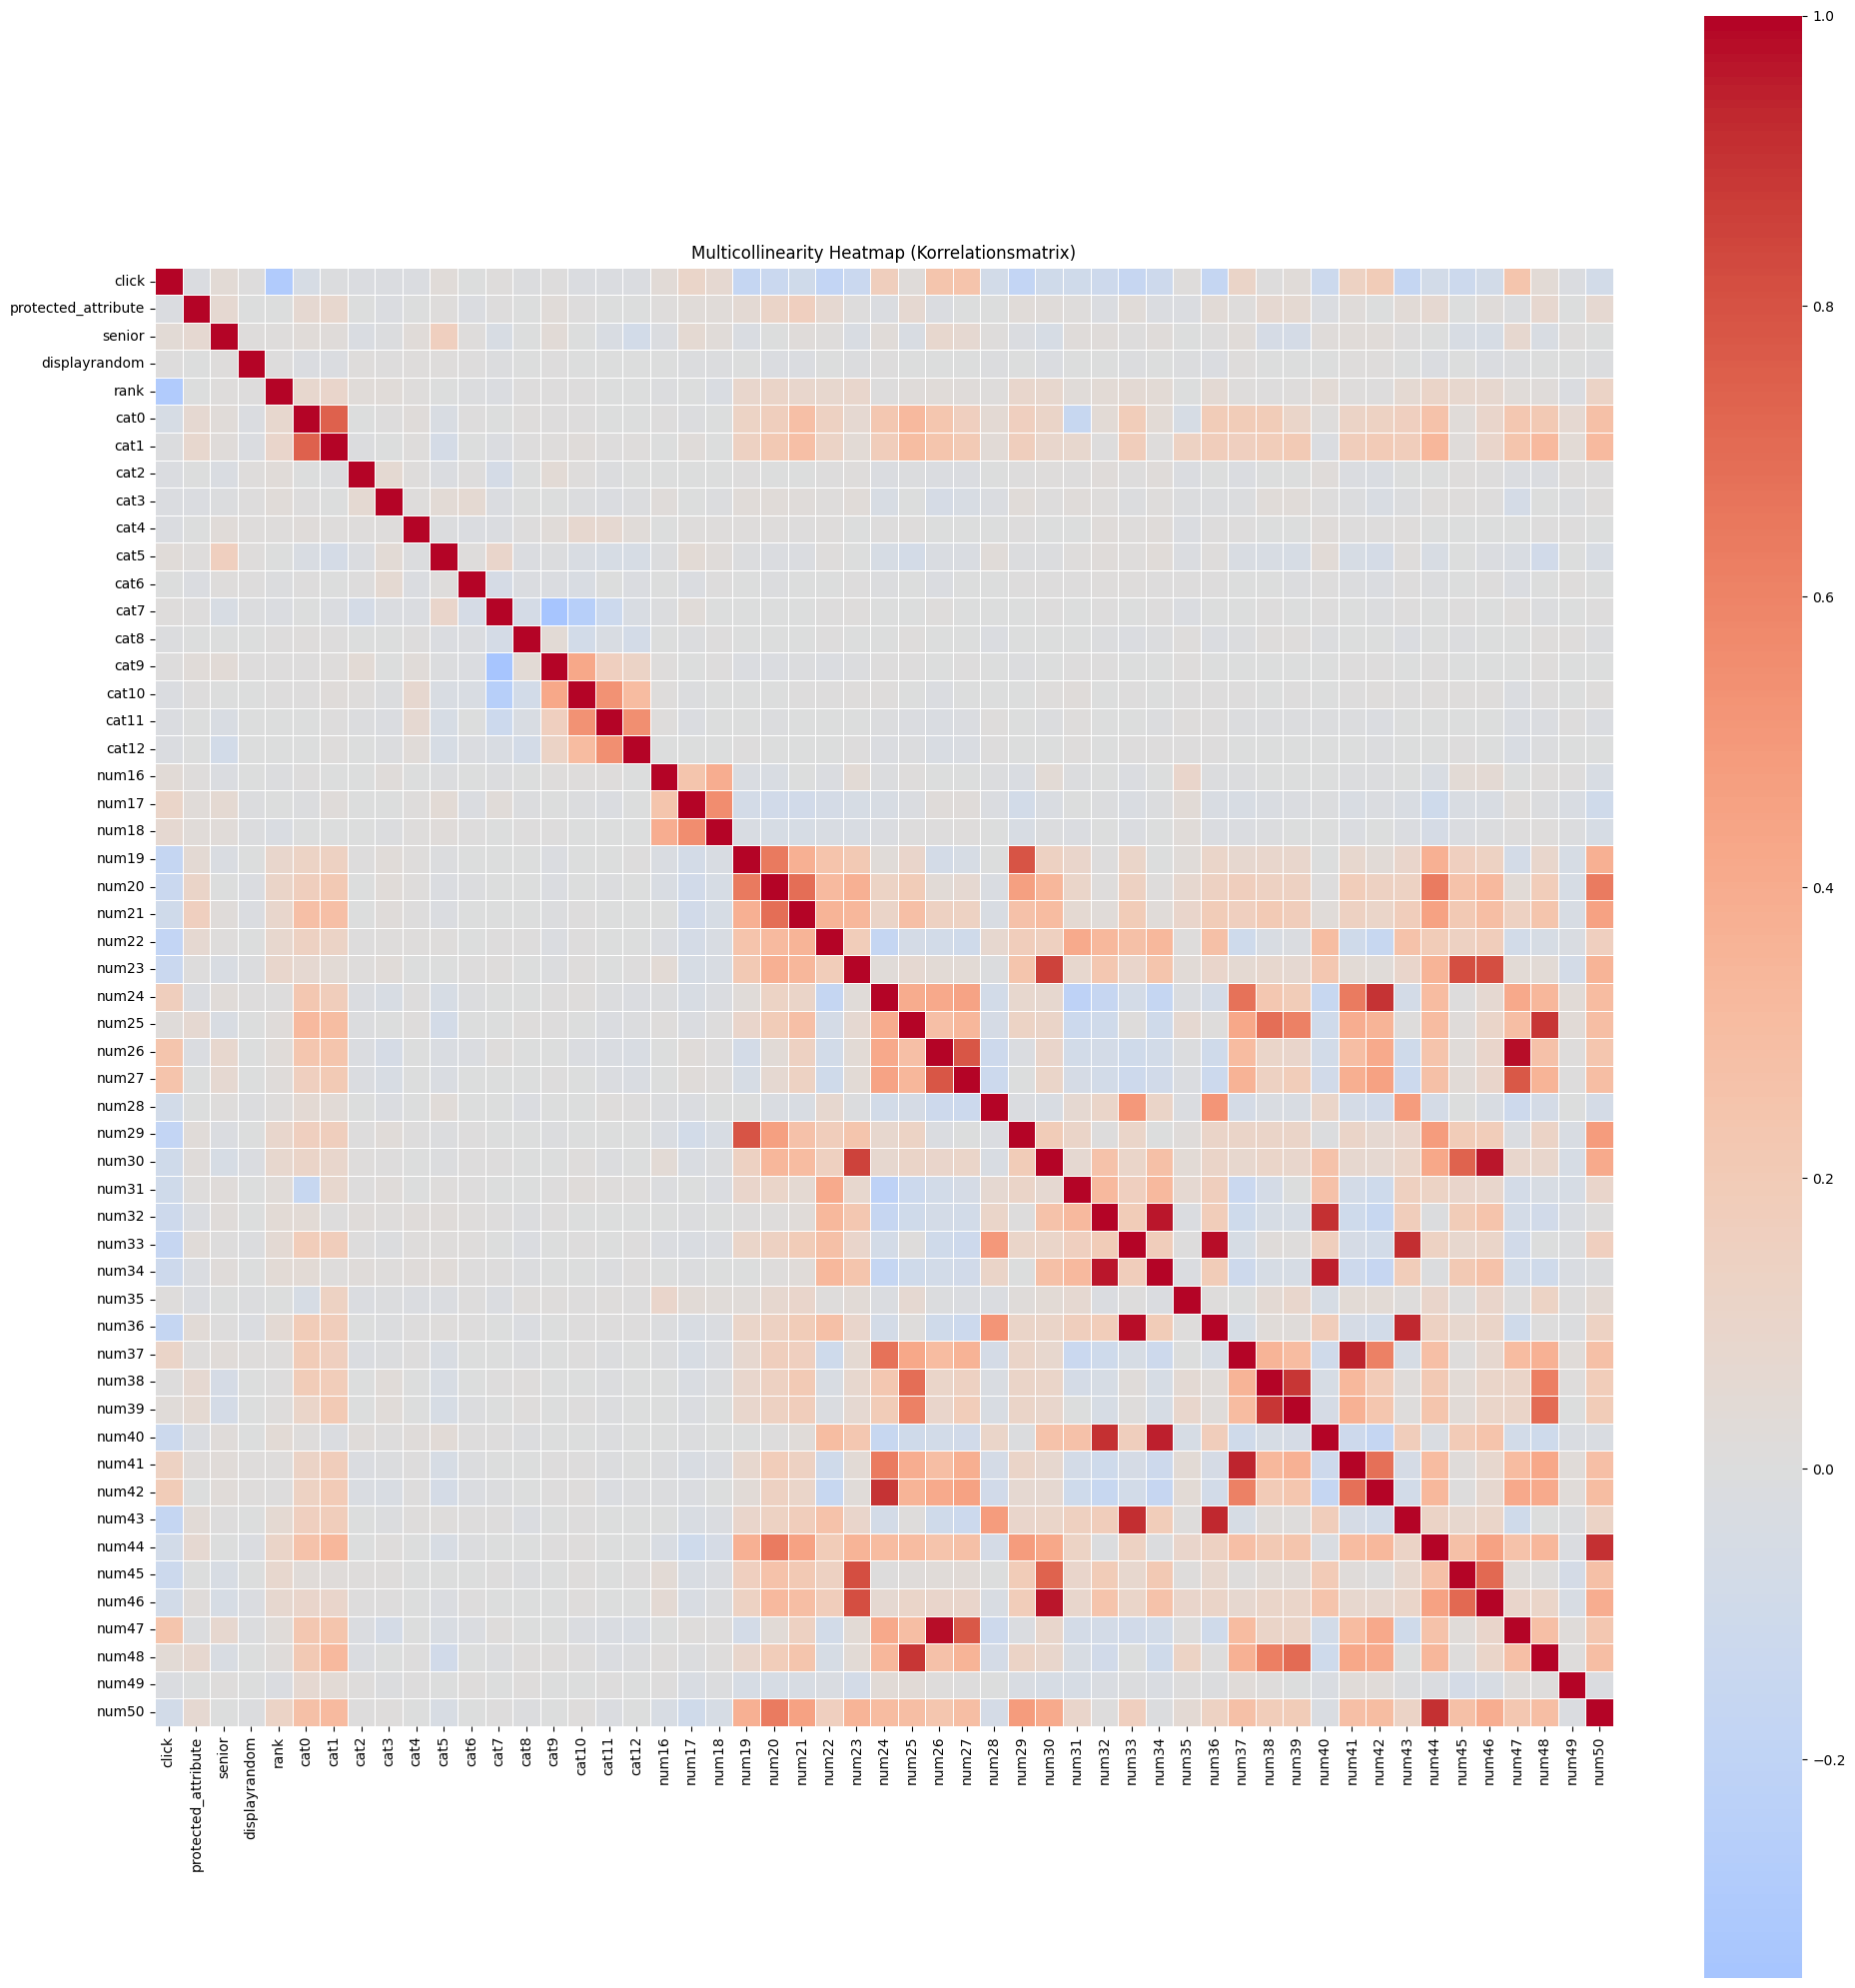

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV-Datei laden
df = pd.read_csv("data/fairjob_balanced.csv")

# Optional: irrelevante ID-Spalten entfernen
df = df.drop(columns=['user_id', 'product_id', 'impression_id'], errors='ignore')

# Nur numerische Features auswählen (für Korrelation)
numeric_df = df.select_dtypes(include=['number', 'bool'])

# Korrelationsmatrix berechnen
corr_matrix = numeric_df.corr()

# Heatmap zeichnen
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Multicollinearity Heatmap (Korrelationsmatrix)")
plt.tight_layout()
plt.show()


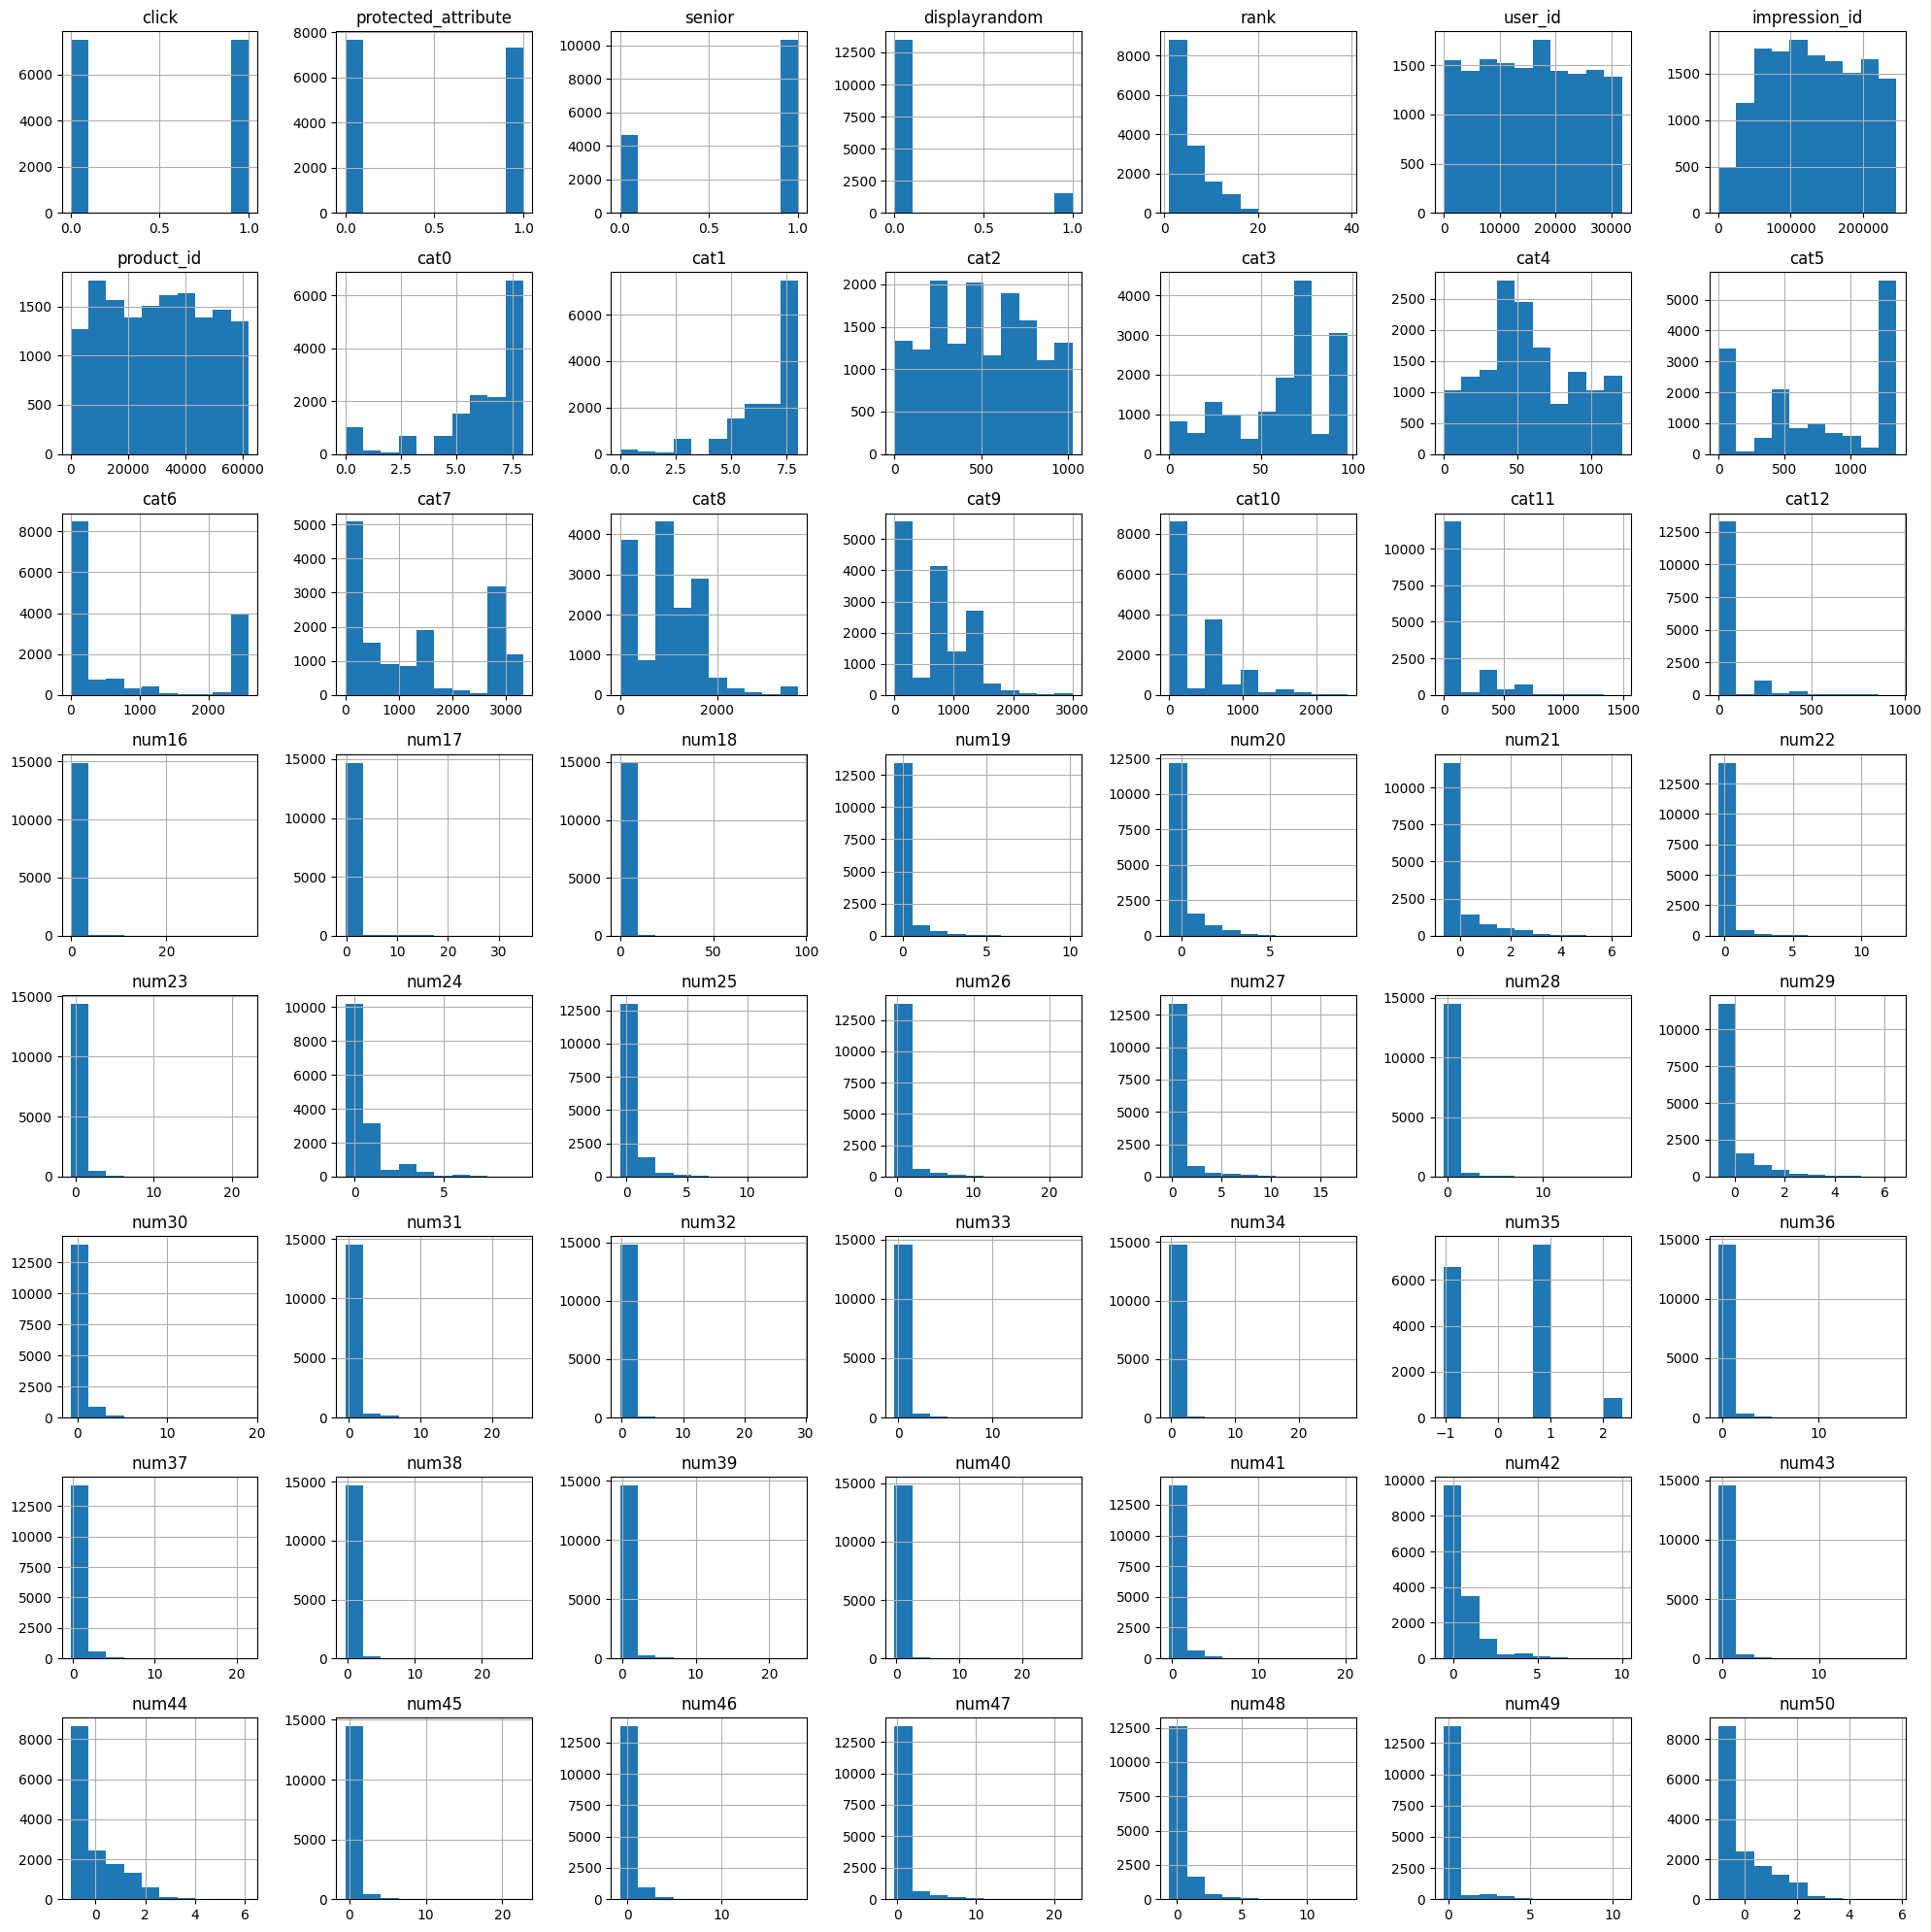

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei laden
df = pd.read_csv("data/fairjob_balanced.csv")

# Auswahl numerischer und boolescher Spalten
numeric_bool_cols = df.select_dtypes(include=['number', 'bool'])

# Histogramm erzeugen
numeric_bool_cols.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 2997it [12:35,  3.92it/s]                          
/tmp/ipykernel_27449/47763401.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


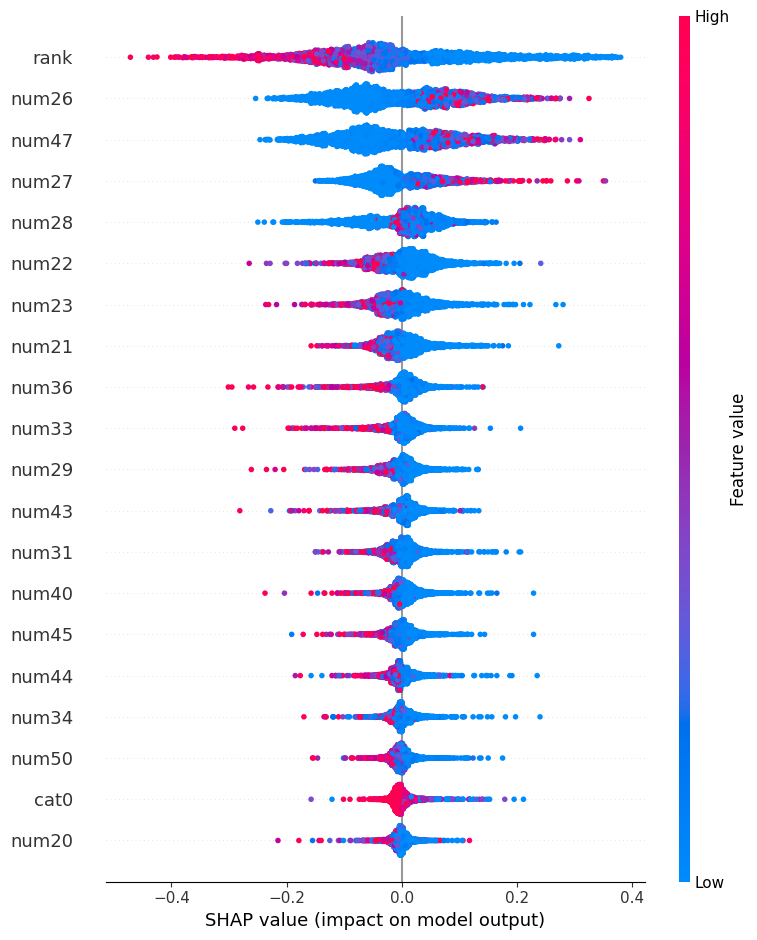

In [36]:
# Sicherstellen, dass alle Features numerisch sind
X = pd.get_dummies(X)
X = X.astype(np.float64)
# SHAP
explainer = shap.Explainer(rf.predict, X_train)
shap_values = explainer(X_test)

# Globaler Einfluss
shap.summary_plot(shap_values, X_test)

SHAP value > 0 → pushes model toward predicting a click

SHAP value < 0 → pushes model away from predicting a click

So, the wider the spread, the more influence the feature has across samples.

Therefore rank has a bi influence on whether someone does not click (negative) and whether someone will click


XGBoost auf balanciertem Datensatz
Confusion Matrix:
[[1139  359]
 [ 330 1168]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7754    0.7603    0.7678      1498
           1     0.7649    0.7797    0.7722      1498

    accuracy                         0.7700      2996
   macro avg     0.7701    0.7700    0.7700      2996
weighted avg     0.7701    0.7700    0.7700      2996

ROC-AUC Score: 0.8501433152525575
Accuracy: 0.7700267022696929


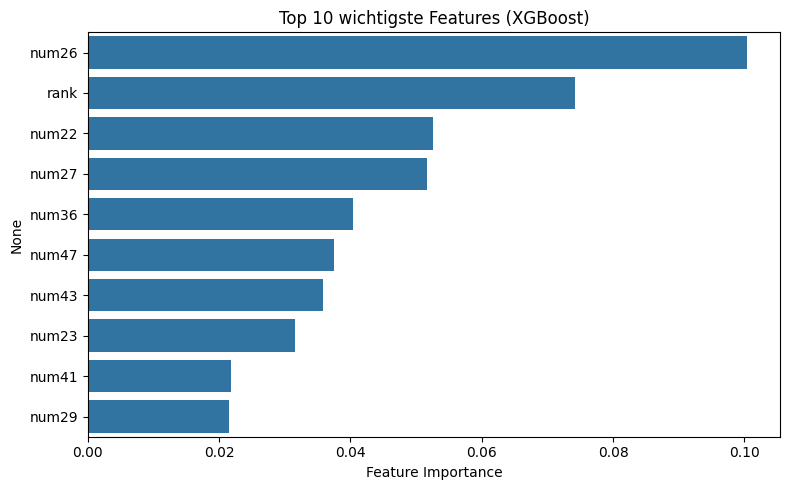

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
import xgboost as xgb

# Lade den balancierten Datensatz
df = pd.read_csv("data/fairjob_balanced.csv")

# Ziel und Features trennen
X = df.drop(columns=["click"])
y = df["click"]

# Kategorische Variablen ggf. kodieren (falls notwendig)
X = pd.get_dummies(X)

# Optional: geschütztes Attribut (z. B. gender proxy), falls du damit arbeitest
protected_attr = "protected_attribute" if "protected_attribute" in df.columns else None
X_protected = df[protected_attr] if protected_attr else None

# Aufteilen in Training und Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_protected = X_protected.loc[X_test.index] if protected_attr else None

print("\n" + "="*60)
print("XGBoost auf balanciertem Datensatz")
print("="*60)

# ⚠️ Kein scale_pos_weight nötig bei balancierten Daten
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Wichtigste Features anzeigen (Top 10)
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 wichtigste Features (XGBoost)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [39]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Create a dedicated RNG and pass it to SHAP (where supported)
rng = np.random.default_rng(42)

# SHAP summary plot with explicit RNG (in new versions only)
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("output/shap_summary_xgboost.png", bbox_inches='tight')
plt.close()

/tmp/ipykernel_27449/2687387793.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


In [2]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Daten laden
df = pd.read_csv("data/fairjob_balanced.csv")

# Optional: irrelevante Spalten entfernen
drop_cols = ['user_id', 'product_id', 'impression_id']
df = df.drop(columns=drop_cols, errors='ignore')

# Features und Ziel
X = df.drop(columns=['click'])
y = df['click']

# One-Hot-Encoding (nur wenn nötig)
X = pd.get_dummies(X, drop_first=True)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Modell: XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:14:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

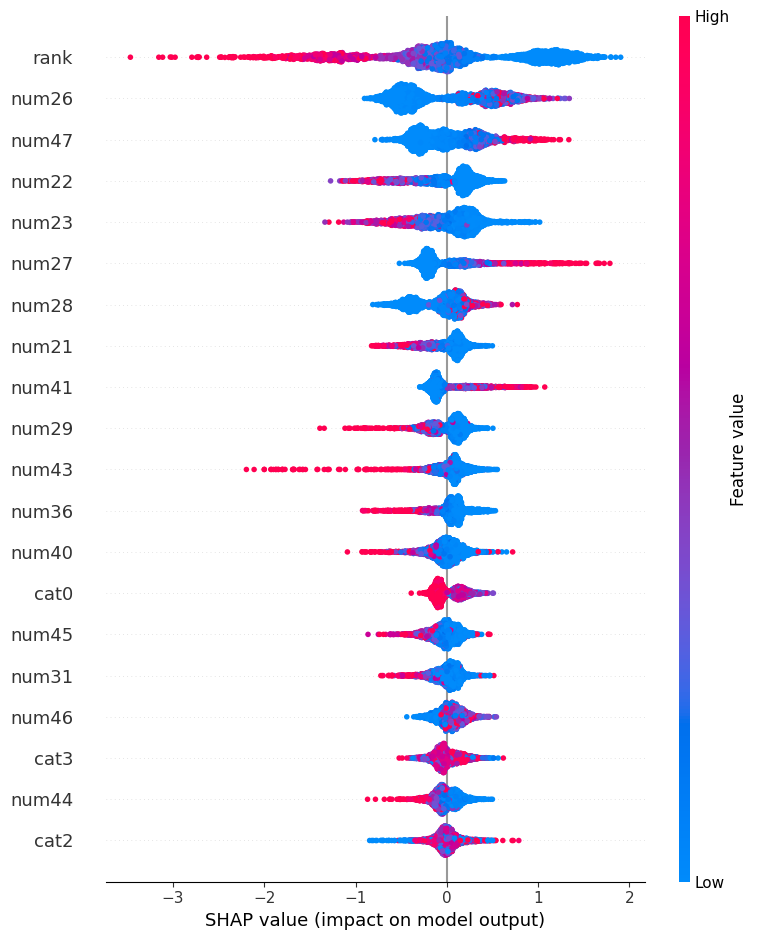

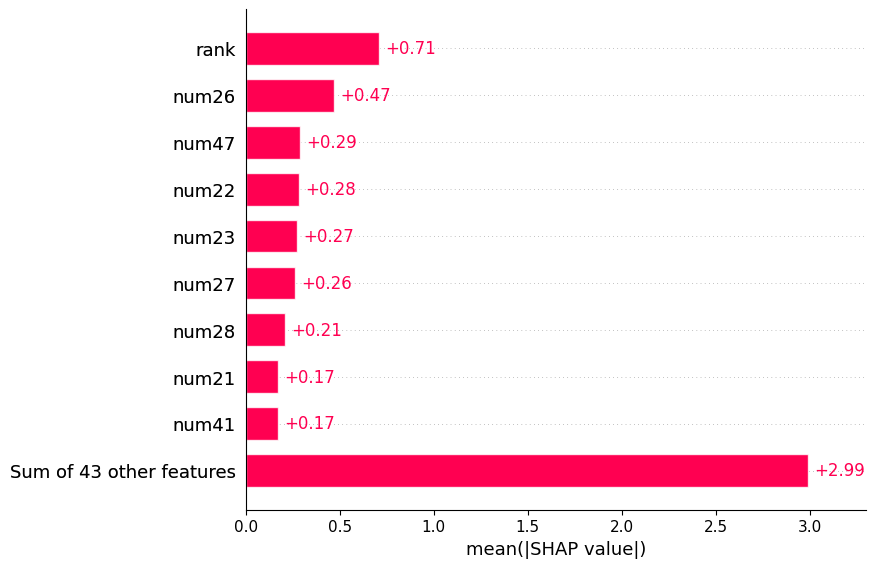

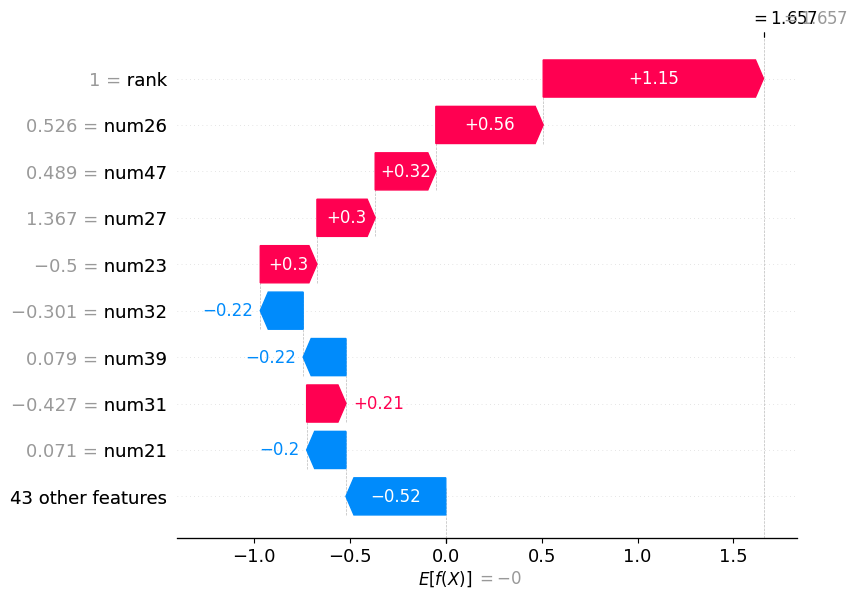

In [3]:
# SHAP initialisieren
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP Summary (global)
shap.summary_plot(shap_values, X_test)

# SHAP Bar-Plot (Top Features)
shap.plots.bar(shap_values)

# Lokale Erklärung für einzelne Vorhersage
shap.plots.waterfall(shap_values[0])



LIME Erklärung (Top Features):
[('rank <= 1.00', 0.17103113356360813), ('num27 > 0.24', 0.10389629245900912), ('num49 <= -0.26', 0.10093564787307369), ('num21 > -0.07', -0.07475954956470027), ('num43 > -0.18', -0.07215918861745065), ('num16 <= -0.11', -0.06002742386238024), ('num36 > -0.19', -0.05809401885696434), ('num18 <= -0.13', -0.046688577868656274), ('-0.31 < num28 <= -0.18', 0.046378450092592366), ('7.00 < cat0 <= 8.00', -0.04391997992877346)]


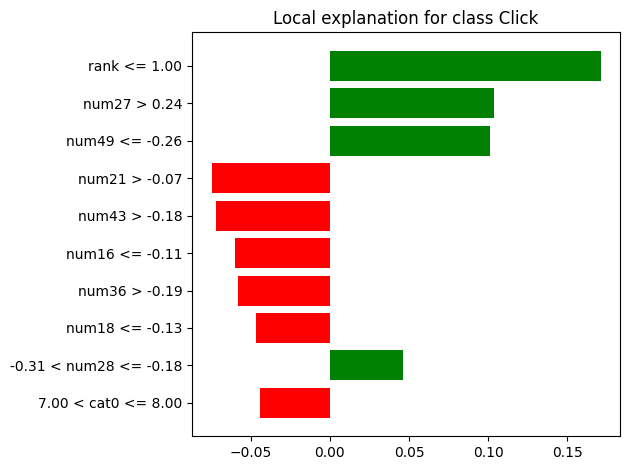

In [13]:
#%pip install lime  # Falls noch nicht installiert

import numpy as np
import lime
import lime.lime_tabular
from IPython.display import display, HTML

# LIME-Instanz erzeugen
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Click', 'Click'],
    mode='classification',
    discretize_continuous=True
)

# Beispiel-Erklärung für Sample i
i = 0  # Beispielindex
instance = X_test.iloc[i].values
exp = explainer_lime.explain_instance(instance, model.predict_proba, num_features=10)

# Ausgabe als HTML (funktioniert nur nach Definition von exp!)
html_output = exp.as_html()
display(HTML(html_output))

# Optional: als Text + Plot
print("\nLIME Erklärung (Top Features):")
print(exp.as_list())

# Oder als Plot
fig = exp.as_pyplot_figure()
fig.tight_layout()


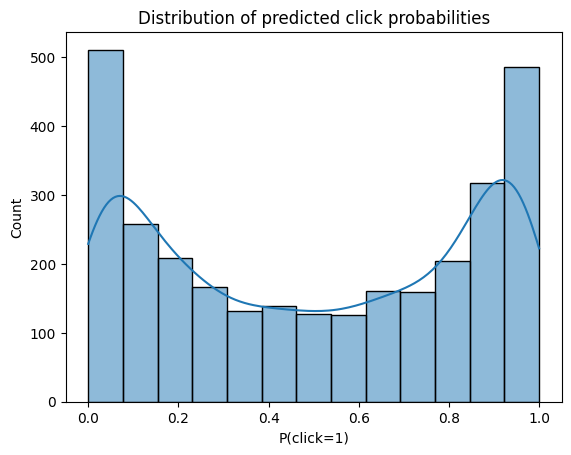

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

proba = model.predict_proba(X_test)[:, 1]
sns.histplot(proba, kde=True)
plt.title("Distribution of predicted click probabilities")
plt.xlabel("P(click=1)")
plt.show()


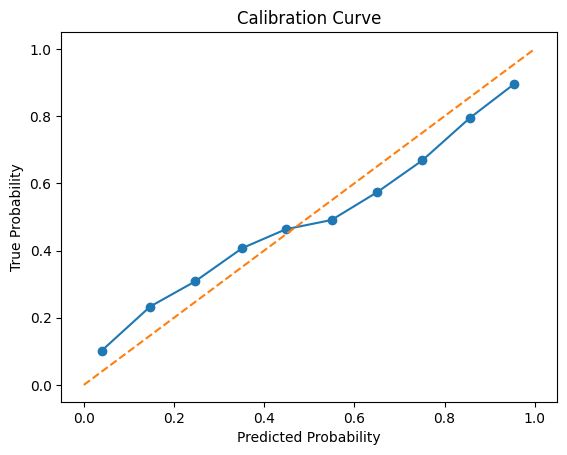

In [10]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


In [15]:
# 🔁 Erzeuge die LIME-Erklärung für Instanz i
i = 0  # oder ein anderer Index
exp = explainer_lime.explain_instance(X_test.iloc[i].values, model.predict_proba, num_features=10)

# 📦 LIME Dictionary erzeugen (das fehlt dir!)
lime_expl_dict = dict(exp.as_list())

# 📦 SHAP Dictionary für dieselbe Instanz
shap_expl_dict = dict(zip(X_test.columns, shap_values[i].values))

# 📊 Top-5 Feature Rankings
top_shap = pd.Series(shap_expl_dict).abs().nlargest(5)
top_lime = pd.Series(lime_expl_dict).abs().nlargest(5)

# 📋 Ausgabe
print("Top SHAP Features:")
print(top_shap)

print("\nTop LIME Features:")
print(top_lime)


Top SHAP Features:
rank     1.148930
num26    0.559986
num47    0.316245
num27    0.303795
num23    0.295553
dtype: float32

Top LIME Features:
rank <= 1.00      0.158095
num27 > 0.24      0.101889
num49 <= -0.26    0.096553
num21 > -0.07     0.069545
num16 <= -0.11    0.064840
dtype: float64


1. MEMC Score: Global Fidelity via Iterative Feature Removal
Goal:
Measure how strongly the model depends on the top SHAP features.

In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score

# 1. Rank by global mean |SHAP|
global_shap_importance = np.abs(shap_values.values).mean(axis=0)
ranked_idx = np.argsort(global_shap_importance)[::-1]
feature_names = X_test.columns

# 2. Define removal sets
removal_sets = [ [feature_names[ranked_idx[i]] for i in range(k)] for k in [1, 3, 5] ]

memc_scores = []

# 3. Evaluate AUC after zeroing top-k features
original_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

for features_to_remove in removal_sets:
    X_mutated = X_test.copy()
    X_mutated[features_to_remove] = 0
    auc_removed = roc_auc_score(y_test, model.predict_proba(X_mutated)[:, 1])
    delta_auc = original_auc - auc_removed
    memc_scores.append(delta_auc)

memc_score = np.mean(memc_scores)
print("MEMC Score:", round(memc_score, 4))


MEMC Score: 0.1271


Top-k Feature Selection AUPRC
Goal:
Test if SHAP top-k features are better than model-internal feature_importances_.

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

auprc_shap_3 = auprc_shap_5 = auprc_shap_10 = None
auprc_model_3 = auprc_model_5 = auprc_model_10 = None

k_values = [3, 5, 10]
for k in k_values:
    topk_shap_features = feature_names[ranked_idx[:k]]
    model_shap = XGBClassifier(eval_metric="logloss", random_state=42)
    model_shap.fit(X_train[topk_shap_features], y_train)
    proba_shap = model_shap.predict_proba(X_test[topk_shap_features])[:, 1]
    auprc_shap = average_precision_score(y_test, proba_shap)

    topk_model_features = feature_names[np.argsort(model.feature_importances_)[::-1][:k]]
    model_builtin = XGBClassifier(eval_metric="logloss", random_state=42)
    model_builtin.fit(X_train[topk_model_features], y_train)
    proba_builtin = model_builtin.predict_proba(X_test[topk_model_features])[:, 1]
    auprc_model = average_precision_score(y_test, proba_builtin)

    if k == 3:
        auprc_shap_3 = auprc_shap
        auprc_model_3 = auprc_model
    elif k == 5:
        auprc_shap_5 = auprc_shap
        auprc_model_5 = auprc_model
    elif k == 10:
        auprc_shap_10 = auprc_shap
        auprc_model_10 = auprc_model


 3. SHAP-LIME Agreement (Local Fidelity)
 We only compare the overlaping features

In [20]:
from scipy.stats import spearmanr

# Get LIME as a Series
lime_weights_series = pd.Series(lime_weights_dict)

# Get SHAP as a Series
shap_series = pd.Series(shap_vector, index=X_test.columns)

# Intersecting features
common_features = lime_weights_series.index.intersection(shap_series.index)

# Subset both
shap_vals_sub = shap_series[common_features].abs()
lime_vals_sub = lime_weights_series[common_features].abs()

# Correlation (only if more than 1 element)
if len(common_features) > 1:
    corr, _ = spearmanr(shap_vals_sub, lime_vals_sub)
    print(f"Spearman correlation (LIME vs SHAP on common features): {corr:.3f}")
else:
    print("Not enough common features to compute correlation.")


Not enough common features to compute correlation.


 4. Infidelity & Sensitivity

In [21]:
#4a. Infidelity (approximate)
delta = np.random.normal(0, 0.01, size=X_test.shape)
f_x = model.predict_proba(X_test)[:, 1]
f_x_perturbed = model.predict_proba(X_test - delta)[:, 1]
shap_lin_approx = (delta * shap_values.values).sum(axis=1)

infidelity = np.mean(np.abs(shap_lin_approx - (f_x - f_x_perturbed)))
print("Infidelity Score:", round(infidelity, 4))

Infidelity Score: 0.067


In [28]:
#Max sensitivity
epsilon = np.random.normal(0, 0.01, size=X_test.shape)
phi_x = shap_values.values
phi_x_eps = explainer(X_test + epsilon).values

sensitivity = np.max(np.linalg.norm(phi_x_eps - phi_x, axis=1) / np.linalg.norm(epsilon, axis=1))
print("Max Sensitivity:", round(sensitivity, 4))
# If you already ran the infidelity block
infidelity_score = infidelity  # or whatever name you used in that block

# If you calculated max sensitivity earlier
max_sensitivity = sensitivity  # or assign directly if already printed

# Monotonicity score
monotonicity_score = rho  # from the Spearman correlation on 'rank'


Max Sensitivity: 28.5096


Monotonicity Check (on rank)

In [24]:
from scipy.stats import spearmanr

df_with_shap = X_test.copy()
# get SHAP values for 'rank'
rank_idx = list(X_test.columns).index('rank')
df_with_shap['shap_rank'] = shap_values[:, rank_idx].values

# bin into deciles (with duplicates dropped)
df_with_shap['rank_bin'] = pd.qcut(df_with_shap['rank'], q=10, duplicates='drop')

# mean SHAP by bin
shap_means = df_with_shap.groupby('rank_bin')['shap_rank'].mean()

# test monotonic trend (Spearman correlation with bin order)
rho, _ = spearmanr(range(len(shap_means)), shap_means)
print(f"Monotonicity score for 'rank': Spearman ρ = {rho:.3f}")


Monotonicity score for 'rank': Spearman ρ = -1.000


/tmp/ipykernel_2981/1769146819.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shap_means = df_with_shap.groupby('rank_bin')['shap_rank'].mean()


In [29]:
import pandas as pd

# Fill these with your actual values
summary = {
    "Metric": [
        "MEMC Score",
        "AUPRC (SHAP top-3)",
        "AUPRC (model top-3)",
        "AUPRC (SHAP top-5)",
        "AUPRC (model top-5)",
        "AUPRC (SHAP top-10)",
        "AUPRC (model top-10)",
        "Spearman ρ (SHAP vs LIME)",
        "Infidelity Score",
        "Max Sensitivity",
        "Monotonicity ρ (rank)"
    ],
    "Value": [
        round(memc_score, 4),
        round(auprc_shap_3, 4),
        round(auprc_model_3, 4),
        round(auprc_shap_5, 4),
        round(auprc_model_5, 4),
        round(auprc_shap_10, 4),
        round(auprc_model_10, 4),
        spearman_corr if 'spearman_corr' in locals() else "N/A",
        round(infidelity_score, 4),
        round(max_sensitivity, 4),
        round(monotonicity_score, 3)
    ]
}

# Create and display DataFrame
eval_table = pd.DataFrame(summary)
print(eval_table)

# Optional: Save to CSV or Markdown
eval_table.to_csv("evaluation_summary.csv", index=False)
# eval_table.to_markdown("evaluation_summary.md", index=False)


                       Metric    Value
0                  MEMC Score   0.1271
1          AUPRC (SHAP top-3)   0.7788
2         AUPRC (model top-3)   0.7756
3          AUPRC (SHAP top-5)   0.8067
4         AUPRC (model top-5)   0.8186
5         AUPRC (SHAP top-10)   0.8249
6        AUPRC (model top-10)   0.8298
7   Spearman ρ (SHAP vs LIME)      N/A
8            Infidelity Score    0.067
9             Max Sensitivity  28.5096
10      Monotonicity ρ (rank)     -1.0
